# Donor - Receiver Attribute Difference Analysis

In [2]:
# imports
import yaml
import pandas as pd
import numpy as np
import math
import os
import random
import seaborn as sns 
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify

sns.set(font_scale=1.8)

In [3]:
# read configuration (algorithm parameters etc) into dictionary
with open('../data/config.yaml', 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

## read in the attributes table for all donors and receivers

In [4]:
# read donor attributes
dtAttrDonor = pd.read_csv('../data/all_attrs_donors.csv')
dtAttrDonor['sand_frac'] = (dtAttrDonor['sand_frac']/100).round(2)
dtAttrDonor['clay_frac'] = (dtAttrDonor['clay_frac']/100).round(2)
dtAttrDonor['prcFlatUpland'] = (dtAttrDonor['prcFlatUpland']*100).round(0)
dtAttrDonor['prcFlatLowland'] = (dtAttrDonor['prcFlatLowland']*100).round(0)
dtAttrDonor['prcFlatTotal'] = (dtAttrDonor['prcFlatTotal']*100).round(0)

# read receiver attributes
dtAttrReceiver = pd.read_csv('../data/all_attrs_receivers.csv')
dtAttrReceiver['sand_frac'] = (dtAttrReceiver['sand_frac']/100).round(2)
dtAttrReceiver['clay_frac'] = (dtAttrReceiver['clay_frac']/100).round(2)
dtAttrReceiver['prcFlatUpland'] = (dtAttrReceiver['prcFlatUpland']*100).round(0)
dtAttrReceiver['prcFlatLowland'] = (dtAttrReceiver['prcFlatLowland']*100).round(0)
dtAttrReceiver['prcFlatTotal'] = (dtAttrReceiver['prcFlatTotal']*100).round(0)


## load donor-receiver pairing and compute attribute difference

In [5]:
# loop through regionalization algorithms and scenarios
statsAll = dfDiff = pd.DataFrame()
for reg_alg in ['kmeans_clust','kmedoids_clust','gower_dist','random_forest']:
    for reg_scenario in ['hlr', 'camels']:
        
        pair_file = '../output/donor_' + reg_scenario + '_' + reg_alg + '.csv'
        dtDonor =  pd.read_csv(pair_file)
        
        ## compute donor-receiver attribute difference
        # first merge receiver attributes with donor table
        dt1 = pd.merge(dtDonor[['id','tag','donor','distSpatial']], dtAttrReceiver[['id'] + config['attrs'][reg_scenario]],on='id')

        # then merge in donor attributes
        dt2 = pd.merge(dt1, dtAttrDonor[['id'] + config['attrs'][reg_scenario]],left_on='donor',right_on='id',suffixes=("_r", "_d"))

        # compute donor-receiver attribute difference
        for x in config['attrs'][reg_scenario]:
            dt2[x+'_diff'] = abs(dt2[x+'_d'] - dt2[x+'_r']).round(2)
        
        # add to the overall dataframe for differences
        cols = [c1 for c1 in dt2.columns if c1.endswith("_diff")]
        dt2 = dt2[['id_r'] + cols]
        dt2.columns = [x.replace("_diff","",1) for x in dt2.columns]
        dt2 = dt2.rename(columns={'id_r':'id'}) 
        dt2.insert(1,column="reg_scenario",value=reg_scenario)
        dt2.insert(1,column="reg_algorithm",value=reg_alg)
        dfDiff = dfDiff.append(dt2)
                    
        # summarize donor-receiver attribute differences
        stats = None
        for a1 in config['attrs'][reg_scenario]:
            x = dt2[a1].describe().to_frame()
            x.columns = [a1]
            if stats is None:
                stats = x
            else:
                stats = stats.join(x)   
        stats.insert(0, column="reg_scenario",value=reg_scenario)
        stats.insert(0, column="reg_algorithm",value=reg_alg)
        
        statsAll = statsAll.append(stats)
        
statsAll.to_csv("../output/stats_donor_receiver_attribute_difference.csv", index=True)

## randomly chosen donors

In [6]:
# start from the receiver attributes table
dtDonor_rand = dtAttrReceiver.copy()

# load precomputed spatial distance between all receivers and donors
f1 = '../data/dist_spatial_donor_receiver.csv'
if os.path.isfile(f1):
    distSpatial0 = pd.read_csv(f1,index_col=0)
else:
    pass

# maximum distance (result: 729km - smaller than the max distance specified in config)
print("Maximum spatial distance: " + str(distSpatial0.max().max()))

# randomly select a donor for each receiver
dtDonor_rand['donor'] = random.choices(distSpatial0.columns.to_list(),k=len(dtDonor_rand))

Maximum spatial distance: 729


## compute attribute difference for random donors

In [7]:
# merge with donor attributes and compute the differences
attrs = list(set(config['attrs']['hlr'] + config['attrs']['camels']))
dfDiff2 = pd.merge(dtDonor_rand[['id','donor']+attrs], dtAttrDonor[['id']+attrs], left_on = "donor", right_on="id",suffixes=("_r", "_d"))

# compute donor-receiver attribute difference
for x in attrs:
    dfDiff2[x+'_diff'] = abs(dfDiff2[x+'_d'] - dfDiff2[x+'_r']).round(2)
        
# add to the overall dataframe for differences
cols = [c1 for c1 in dfDiff2.columns if c1.endswith("_diff")]
dfDiff2 = dfDiff2[['id_r'] + cols]
dfDiff2.columns = [x.replace("_diff","",1) for x in dfDiff2.columns] 
dfDiff2 = dfDiff2.rename(columns={'id_r':'id'})
dfDiff2['reg_scenario'] = dfDiff2['reg_algorithm'] = 'random'

## Donors chosen based on spatial proximity

In [8]:
# choose donor by spatial distance
dtDonor_sp = dtAttrReceiver.copy()
dtDonor_sp['donor'] = distSpatial0.loc[dtDonor_sp['id']].idxmin(axis=1).to_list()

# merge with donor attributes and compute the differences
attrs = list(set(config['attrs']['hlr'] + config['attrs']['camels']))
dfDiff3 = pd.merge(dtDonor_sp[['id','donor']+attrs], dtAttrDonor[['id']+attrs], left_on = "donor", right_on="id",suffixes=("_r", "_d"))

# compute donor-receiver attribute difference
for x in attrs:
    dfDiff3[x+'_diff'] = abs(dfDiff3[x+'_d'] - dfDiff3[x+'_r']).round(2)
        
# add to the overall dataframe for differences
cols = [c1 for c1 in dfDiff3.columns if c1.endswith("_diff")]
dfDiff3 = dfDiff3[['id_r'] + cols]
dfDiff3.columns = [x.replace("_diff","",1) for x in dfDiff3.columns] 
dfDiff3 = dfDiff3.rename(columns={'id_r':'id'})
dfDiff3['reg_scenario'] = dfDiff3['reg_algorithm'] = 'spatial_proximity'


In [9]:
# combine with other (physical similarity based) scenarios
dfDiff1 = dfDiff.append(dfDiff2)
dfDiff1 = dfDiff1.append(dfDiff3)
dfDiff1 = dfDiff1.melt(id_vars=['id','reg_algorithm','reg_scenario'])
dict = {'kmeans_clust':'km', 'kmedoids_clust':'kmd', 'gower_dist':'gw', 'random_forest':'urf','spatial_proximity':'sp', 'random':'rd'}
dfDiff1 = dfDiff1.replace({'reg_algorithm': dict})

## Compare receiver-donor attribute difference in boxplots

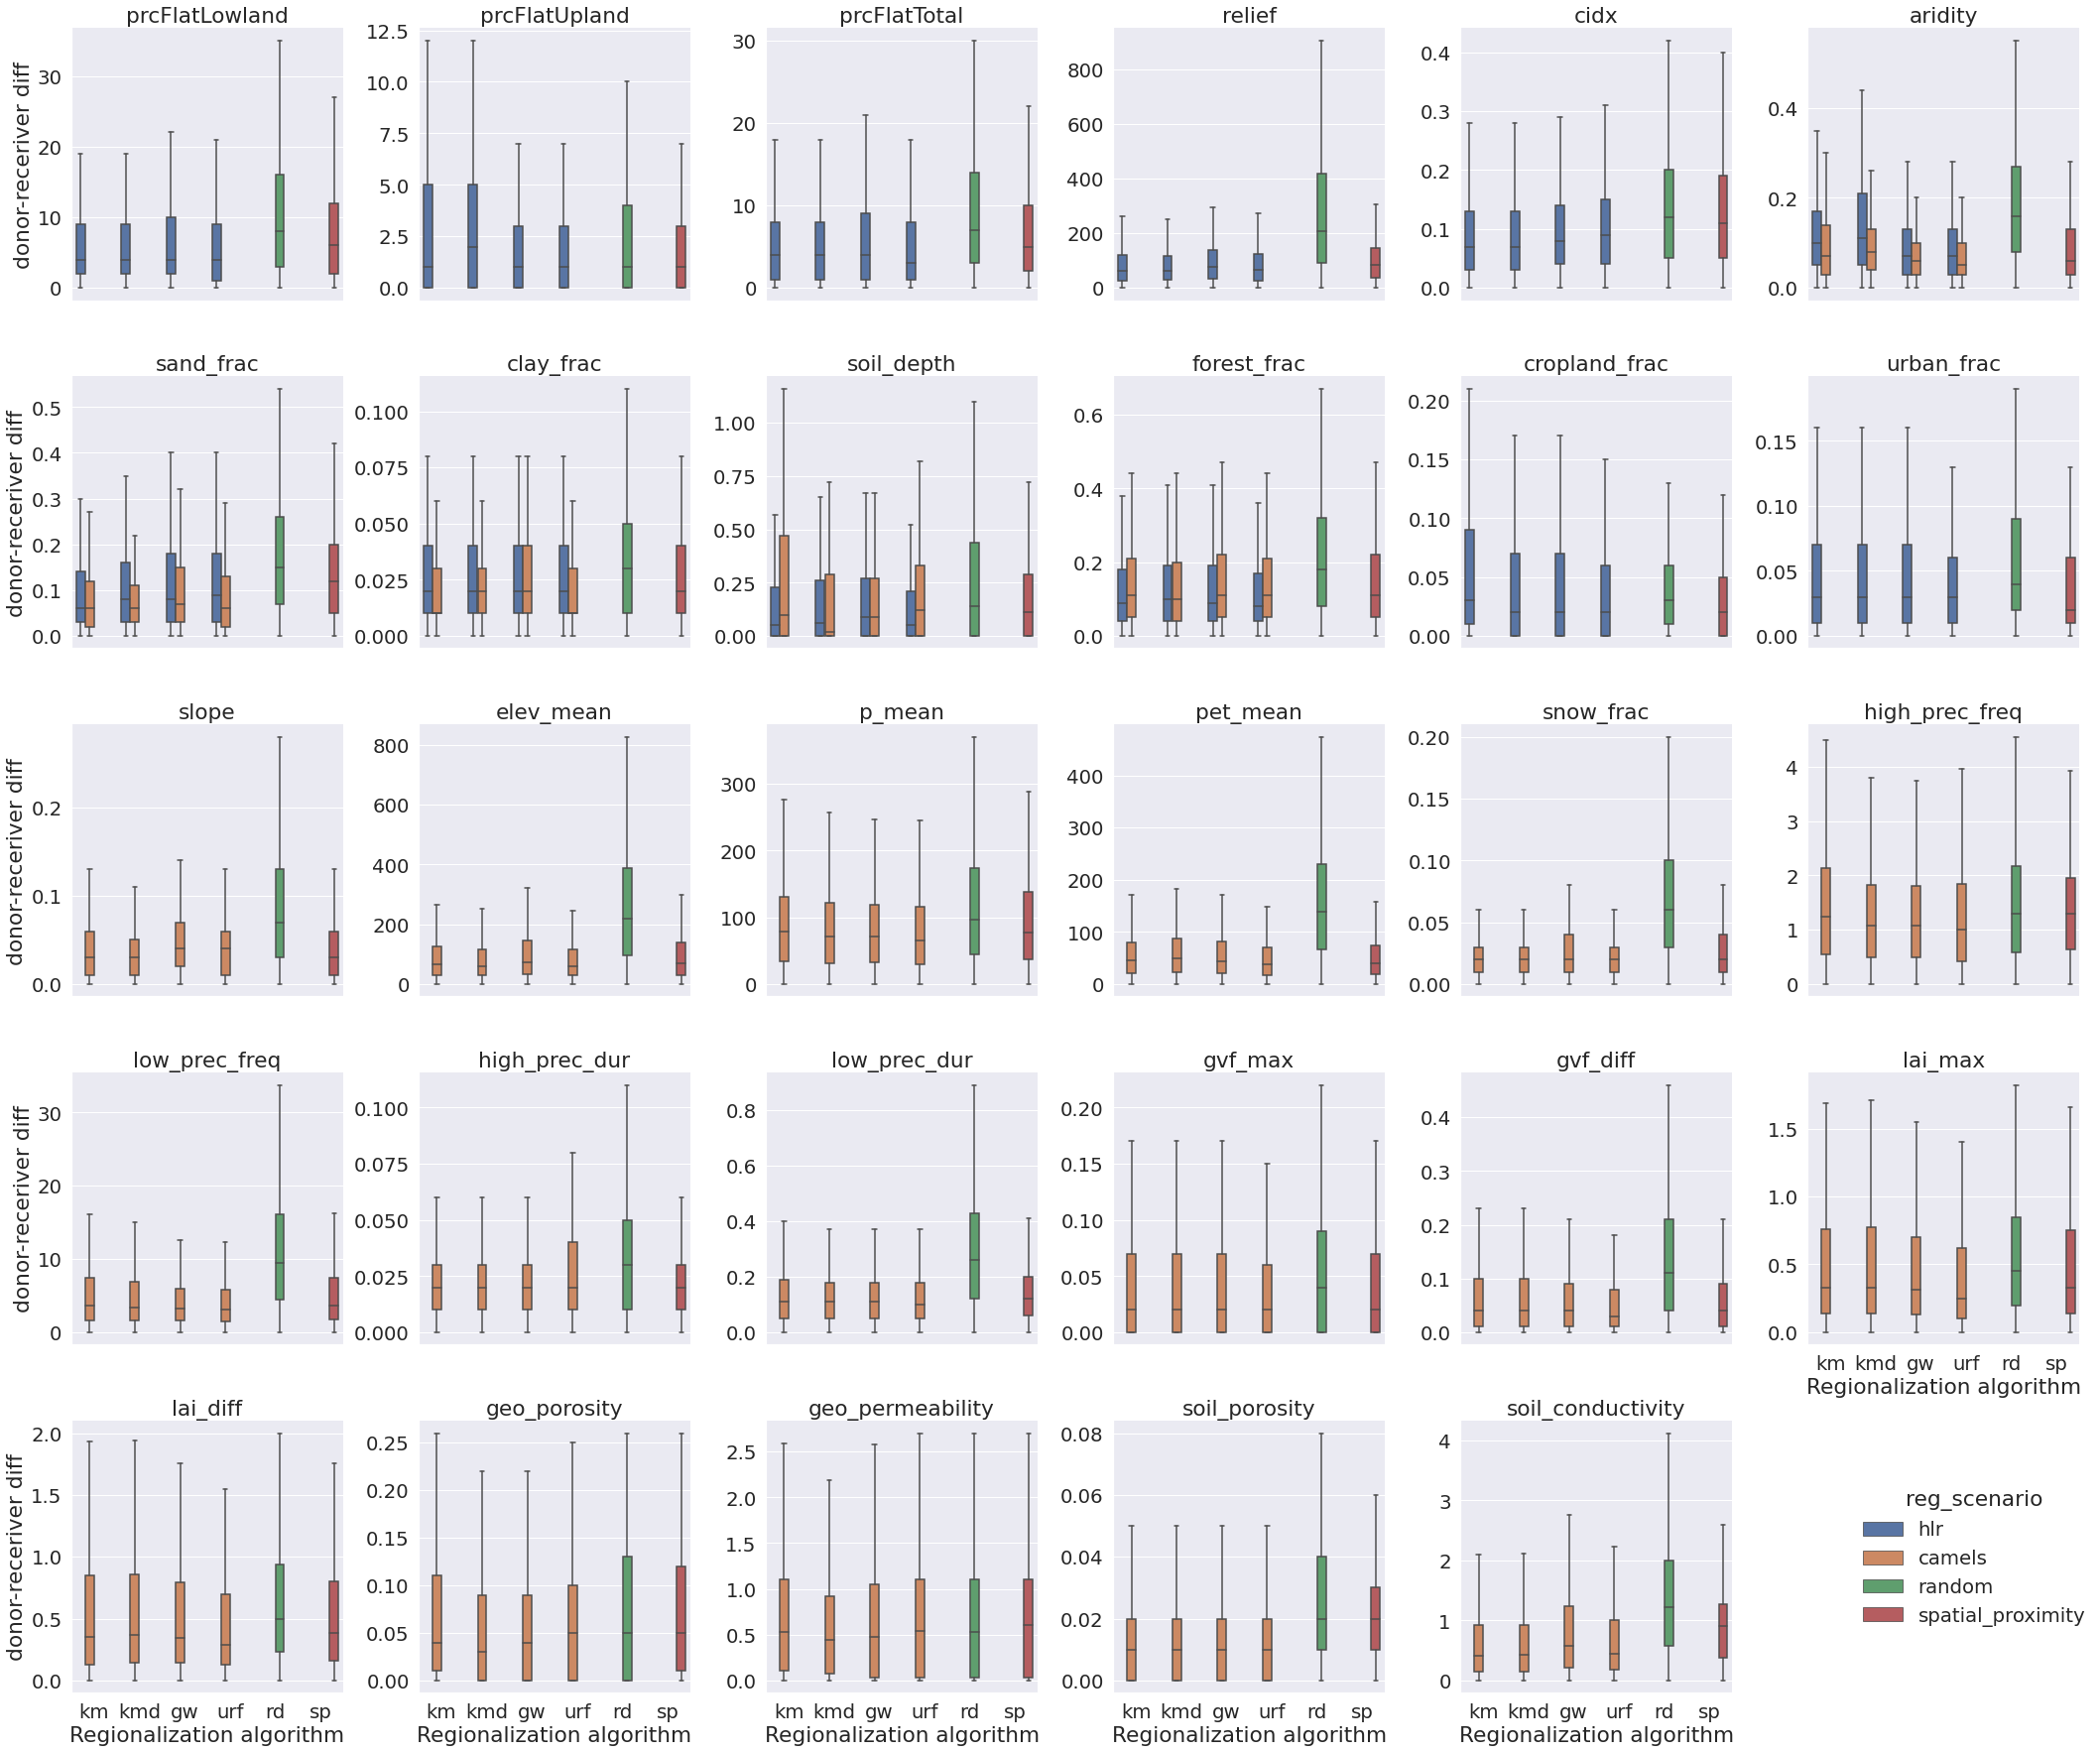

In [11]:
# make boxplots of attribute differences
g = sns.catplot(data= dfDiff1, kind="box",x="reg_algorithm", y="value", col="variable", col_wrap=6, hue='reg_scenario',
                showfliers = False,sharey=False,legend=True)
g.set_xlabels('Regionalization algorithm')
g.set_ylabels('donor-receriver diff')

for col_key,ax in g.axes_dict.items():
    ax.set_title(col_key)
sns.move_legend(g, "lower right", bbox_to_anchor=(.9, .07))
plt.savefig("../figs/boxplot_attr_diff.png",dpi=500)


## visualize attribute differences in spatial maps

In [ ]:
# load catchment hydrofabric data and merge with attribute difference table computed above
shp1 = gpd.read_file("../../datasets/gpkg_v0/catchment_data.geojson")
shp1 = shp1.merge(dfDiff1.loc[dfDiff1['reg_algorithm'] != 'rand'],left_on="id",right_on="id")
shp1['tag'] = shp1['reg_algorithm'] + '.' + shp1['reg_scenario']
print(shp1.head())

In [44]:
# define classification bins for mapping donor-receiver attribute difference 
# only inner points need to be defined here. max will be determined from data later and min will be automatically determined by
#   mapclassify.UserDefined based on the data
threshs0 = {
    'elev_mean': [10,50,100,200],
    'slope': [0.01,0.05,0.1,0.2,],
    'prcFlatLowland': [10,25,50,75],
    'prcFlatUpland': [10,25,50,75],
    'prcFlatTotal': [10,25,50,75],
    'relief': [10,50,200,400],
    'cidx': [0.05,0.1,0.2,0.3],
    'aridity': [0.05,0.1,0.2,0.3],
    'p_mean': [10,50,100,200],
    'pet_mean': [10,50,100,200],
    'snow_frac': [0.01,0.05,0.1,0.15],
    'high_prec_freq': [0.5,1,2,4],
    'low_prec_freq': [1,5,10,20],
    'high_prec_dur': [0.01,0.05,0.1,0.15],
    'low_prec_dur': [0.05,0.2,0.4,0.6],
    'forest_frac': [0.1,0.3,0.5,0.7],
    'cropland_frac': [0.1,0.3,0.5,0.7],
    'urban_frac': [0.1,0.3,0.5,0.7],
    'gvf_max': [0.1,0.25,0.5,0.75],
    'gvf_diff': [0.1,0.25,0.5,0.75],
    'lai_max': [0.5,1,2,4],
    'lai_diff': [0.5,1,2,4],
    'sand_frac': [0.05,0.2,0.4,0.6],
    'clay_frac': [0.05,0.1,0.15,0.2],
    'soil_porosity': [0.05,0.1,0.15,0.2],
    'soil_conductivity': [1,5,10,20],
    'soil_depth': [0.1,0.3,0.6,1.0],
    'geo_porosity': [0.05,0.1,0.15,0.25],
    'geo_permeability': [1,2,4,6]     
}

In [ ]:
# spatial maps for attribute difference
nplot = 6
for tag1 in shp1['tag'].unique():
    print(tag1)
    if "hlr" in tag1:
        attrs = config['attrs']['hlr']
    else:
        attrs = config['attrs']['camels']
    nfig = math.ceil(len(attrs)/nplot)
    for k in range(nfig):
        vars = attrs[(6*k):(6*(k+1))]
        print(vars)
        fig = plt.figure(figsize=(22,10))
        for i, var in enumerate(vars):
            ax = plt.subplot(2, 3, i + 1)
            shp2 = shp1.loc[(shp1['tag']==tag1) & (shp1['variable']==var)]
            shp2 = shp2[['value','geometry']]
            shp2.dropna()
            
            # plot using UserDefined bins 
            min1 = shp2['value'].min().round(2)-0.01
            max1 = shp2['value'].max().round(2)+0.01 # adjust bounds by 0.01 to avoid unnecessary bins added by maplclassify
            bins1 = [x for x in threshs0[var] if (x>=min1) & (x<=max1)]
            bins1 = bins1 + [max1]
            
            classi = mapclassify.UserDefined(shp2['value'], bins1, lowest=min1)
            classi.plot(shp2,ax=ax, legend=True,cmap="OrRd", axis_on=False,
                        legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5),"interval": True,'fontsize': 15})
            ax.set_title(tag1 +': ' + var)
            ax.margins(0)

        plt.savefig('../figs/map_donor_receiver_attr_diff'+str(k)+'_'+tag1+'.png', bbox_inches="tight", pad_inches=0,facecolor='w')

In [ ]:
# define classification bins for mapping the differences in donor-receiver attribute difference between different algorithms;
# only inner points need to be defined here. max will be determined from data later and min will be automatically determined by
#   mapclassify.UserDefined based on the data
threshs = {
    'elev_mean': [-150,-50, -10,10,50,150],
    'slope': [-0.1,-0.05,-0.01,0.01,0.05,0.1],
    'prcFlatLowland': [-10,-5,-2,2,5,10],
    'prcFlatUpland': [-10,-5,-2,2,5,10],
    'prcFlatTotal': [-10,-5,-2,2,5,10],
    'relief': [-150,-50, -10,10,50,150],
    'cidx': [-0.1,-0.05,-0.01,0.01,0.05,0.1],
    'aridity': [-0.1,-0.05,-0.01,0.01,0.05,0.1],
    'p_mean': [-20,-10,-5,5,10,20],
    'pet_mean': [-20,-10,-5,5,10,20],
    'snow_frac': [-0.1,-0.05,-0.01,0.01,0.05,0.1],
    'high_prec_freq': [-0.8,-0.4,-0.2,0.2,0.4,0.8],
    'low_prec_freq': [-10,-5,-2,2,5,10],
    'high_prec_dur': [-0.1,-0.05,-0.01,0.01,0.05,0.1],
    'low_prec_dur': [-0.2,-0.1,-0.05,0.05,0.1,0.2],
    'forest_frac': [-0.1,-0.05,-0.01,0.01,0.05,0.1],
    'cropland_frac': [-0.1,-0.05,-0.01,0.01,0.05,0.1],
    'urban_frac': [-0.1,-0.05,-0.01,0.01,0.05,0.1],
    'gvf_max': [-0.1,-0.05,-0.01,0.01,0.05,0.1],
    'gvf_diff': [-0.1,-0.05,-0.01,0.01,0.05,0.1],
    'lai_max': [-0.15,-0.1,-0.05,0.05,0.1,0.15],
    'lai_diff': [-0.15,-0.1,-0.05,0.05,0.1,0.15],
    'sand_frac': [-0.15,-0.1,-0.05,0.05,0.1,0.15],
    'clay_frac': [-0.15,-0.1,-0.05,0.05,0.1,0.15],
    'soil_porosity': [-0.1,-0.05,-0.01,0.01,0.05,0.1],
    'soil_conductivity': [-0.5,-0.25,-0.1,0.1,0.25,0.5],
    'soil_depth': [-0.3,-0.2,-0.1,0.1,0.2,0.3],
    'geo_porosity': [-0.1,-0.05,-0.01,0.01,0.05,0.1],
    'geo_permeability': [-1,-0.5,-0.1,0.1,0.5,1]     
}

In [ ]:
# spatial maps comparing donor-receiver attribute difference between different scenarios
# using UserDefined bins
nplot = 6
tags1 = ['urf.camels','urf.hlr','km.camels','km.hlr','kmd.hlr','kmd.camels']
tags2 = ['gower.camels','gower.hlr','gower.camels','gower.hlr','km.hlr','km.camels']
for tag1, tag2 in zip(tags1,tags2):
    #tag2 = tags2[tags1.index(tag1)]
    print(tag1 +' vs '+tag2)
    if "hlr" in tag1:
        attrs = config['attrs']['hlr']
    else:
        attrs = config['attrs']['camels']
    nfig = math.ceil(len(attrs)/nplot)
    for k in range(nfig):
        vars = attrs[(6*k):(6*(k+1))]
        fig = plt.figure(figsize=(22,10))
        for i, var in enumerate(vars):
            ax = plt.subplot(2, 3, i + 1)
            shp2 = shp1.loc[(shp1['tag']==tag1) & (shp1['variable']==var)]
            shp2 = shp2[['id','value','geometry']]
            shp2.dropna()

            shp3 = shp1.loc[(shp1['tag']==tag2) & (shp1['variable']==var)]
            shp3 = shp3[['id','value']]
            shp3.dropna()    
            
            shp = pd.merge(shp2, shp3, on='id',suffixes=("_x", "_y"))
            shp['value'] = shp['value_x'] - shp['value_y']

            # plot using UserDefined bins
            min1 = shp['value'].min().round(2)-0.01
            max1 = shp['value'].max().round(2)+0.01 # adjust bounds by 0.01 to avoid unnecessary bins added by maplclassify
            bins1 = [x for x in threshs[var] if (x>=min1) & (x<=max1)]
            bins1 = bins1 + [max1]
            
            classi = mapclassify.UserDefined(shp['value'], bins1, lowest=min1)
            classi.plot(shp,ax=ax, legend=True,cmap="RdBu", axis_on=False,
                        legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5),"interval": True,'fontsize': 15})
            ax.set_title(var)
            ax.margins(0)

        plt.suptitle('Difference in Donor-Receiver Attribute Difference ('+ tag1 + '- ' + tag2 + ')')
        plt.savefig('../figs/map_diff_attr_diff'+str(k)+'_'+tag1+'_'+tag2+'_UserDefined.png', bbox_inches="tight", pad_inches=0,facecolor='w')

In [ ]:
var1 = 'prcFlatTotal'
alg1 = 'urf'
sce1 = 'hlr'
df1 = dfDiff1[(dfDiff1['variable']==var1) & (dfDiff1['reg_algorithm']==alg1) & (dfDiff1['reg_scenario']==sce1)]
print(df1['value'].describe())
